In [ ]:
%pip install kaggle --quiet
!kaggle datasets download -d marquis03/bean-leaf-lesions-classification

import zipfile
from pathlib import Path

zip_path = Path("bean-leaf-lesions-classification.zip")
out_dir = Path("bean-leaf-lesions-classification")

out_dir.mkdir(exist_ok=True)

with zipfile.ZipFile(zip_path) as z:
    z.extractall(out_dir)



Note: you may need to restart the kernel to use updated packages.



  0%|          | 0.00/155M [00:00<?, ?B/s]
 67%|██████▋   | 104M/155M [00:00<00:00, 1.07GB/s]
100%|██████████| 155M/155M [00:00<00:00, 1.12GB/s]


Dataset URL: https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification
License(s): apache-2.0



In [2]:
# Delete the zip file after successful extraction
if zip_path.exists():
    zip_path.unlink()
    print("Zip file deleted successfully.")
else:
    print("Zip file not found.")

Zip file deleted successfully.


In [1]:
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision import models
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
train_df = pd.read_csv("bean-leaf-lesions-classification/train.csv")
val_df = pd.read_csv("bean-leaf-lesions-classification/val.csv")

train_df["image:FILE"] = "bean-leaf-lesions-classification/" + train_df["image:FILE"]
val_df["image:FILE"] = "bean-leaf-lesions-classification/" + val_df["image:FILE"]

train_df.head()

,image:FILE,category
0,bean-leaf-lesions-classification/train/healthy...,0
1,bean-leaf-lesions-classification/train/healthy...,0
2,bean-leaf-lesions-classification/train/healthy...,0
3,bean-leaf-lesions-classification/train/healthy...,0
4,bean-leaf-lesions-classification/train/healthy...,0


In [3]:
print(train_df.shape)
print(val_df.shape)

(1034, 2)
(133, 2)


Since the dataset has so few rows, we use transfer learning by using a pre-trained model.

In [6]:
print(train_df["category"].value_counts())

category
2    348
1    345
0    341
Name: count, dtype: int64


In [3]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(dataframe["category"]).to(device)

    def __len__(self):
        return self.dataframe.shape[0]
    
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]
        image = Image.open(img_path)
        if self.transform:
            image = (self.transform(image)/255.0).to(device)
        
        return image, label

In [5]:
train_dataset = CustomImageDataset(train_df, transform=transform)
val_dataset = CustomImageDataset(val_df, transform=transform)

View dataset

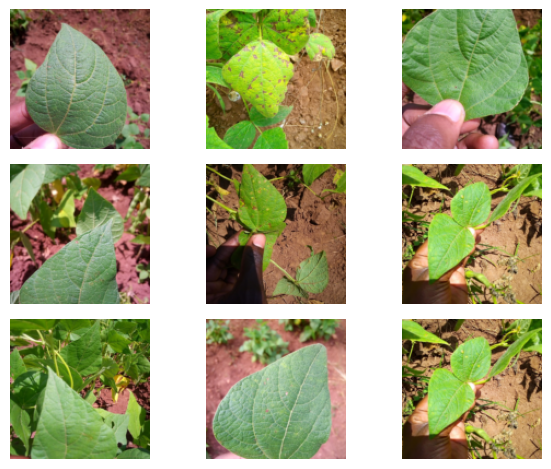

In [6]:
n_rows = 3
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
    for col in range(n_cols):
        image = train_dataset[np.random.randint(0, len(train_dataset))][0].cpu()
        axes[row, col].imshow((image*255.0).squeeze().permute(1, 2, 0))
        axes[row, col].axis("off")

plt.tight_layout()
plt.show()
        

In [7]:
LR = 1e-3
BATCH_SIZE = 4
EPOCHS = 15

In [8]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [9]:
googlenet_model = models.googlenet(weights="DEFAULT").to(device)

In [10]:
for param in googlenet_model.parameters():
    param.requires_grad = True

In [11]:
googlenet_model.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [12]:
num_classes = len(train_df["category"].unique())
num_classes

3

In [13]:
googlenet_model.fc = torch.nn.Linear(in_features=1024, out_features=num_classes).to(device)
googlenet_model.fc

Linear(in_features=1024, out_features=3, bias=True)

Retrain the whole model

In [ ]:
loss_fun = nn.CrossEntropyLoss()
optimizer = Adam(googlenet_model.parameters(), lr=LR)

total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = googlenet_model(inputs)
        loss = loss_fun(outputs, labels)
        total_loss_train += loss.item()
        loss.backward()

        acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
        total_acc_train += acc
        optimizer.step()

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_acc_train_plot.append(round(total_acc_train/len(train_dataset) * 100, 4))
    print(f"Epoch: {epoch + 1}/{EPOCHS} | Loss: {round(total_loss_train/1000, 4)} | Accuracy: {round(total_acc_train/len(train_dataset) * 100, 4)}%")


Epoch: 0/15 | Loss: 0.2513 | Accuracy: 53.1915%
Epoch: 1/15 | Loss: 0.2239 | Accuracy: 61.6054%
Epoch: 2/15 | Loss: 0.191 | Accuracy: 68.5687%
Epoch: 3/15 | Loss: 0.1812 | Accuracy: 71.9536%
Epoch: 4/15 | Loss: 0.1683 | Accuracy: 72.6306%
Epoch: 5/15 | Loss: 0.1602 | Accuracy: 74.8549%
Epoch: 6/15 | Loss: 0.148 | Accuracy: 77.176%
Epoch: 7/15 | Loss: 0.1392 | Accuracy: 79.3037%
Epoch: 8/15 | Loss: 0.124 | Accuracy: 80.8511%
Epoch: 9/15 | Loss: 0.1246 | Accuracy: 81.1412%
Epoch: 10/15 | Loss: 0.1274 | Accuracy: 80.7544%
Epoch: 11/15 | Loss: 0.1173 | Accuracy: 82.3017%
Epoch: 12/15 | Loss: 0.0953 | Accuracy: 85.8801%
Epoch: 13/15 | Loss: 0.1 | Accuracy: 85.0097%
Epoch: 14/15 | Loss: 0.0904 | Accuracy: 87.3308%


Testing

In [21]:
with torch.no_grad():
    total_acc_val = 0
    total_loss_val = 0

    for inputs, labels in val_loader:
        outputs = googlenet_model(inputs)
        loss = loss_fun(outputs, labels)
        total_loss_val += loss.item()

        acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
        total_acc_val += acc

In [22]:
print(f"Test Loss: {round(total_loss_val/1000, 4)} | Test Accuracy: {round(total_acc_val/len(val_dataset) * 100, 2)}%")

Test Loss: 0.0426 | Test Accuracy: 52.63%


Transfer Learning / Fine Tuning

In [24]:
googlenet_model = models.googlenet(weights="DEFAULT").to(device)

for param in googlenet_model.parameters():
    param.requires_grad = False

googlenet_model.fc = torch.nn.Linear(in_features=1024, out_features=num_classes).to(device)
googlenet_model.fc.requires_grad = True

In [26]:
loss_fun = nn.CrossEntropyLoss()
optimizer = Adam(googlenet_model.parameters(), lr=LR)

total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = googlenet_model(inputs)
        loss = loss_fun(outputs, labels)
        total_loss_train += loss.item()
        loss.backward()

        acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
        total_acc_train += acc
        optimizer.step()

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_acc_train_plot.append(round(total_acc_train/len(train_dataset) * 100, 4))
    print(f"Epoch: {epoch + 1}/{EPOCHS} | Loss: {round(total_loss_train/1000, 4)} | Accuracy: {round(total_acc_train/len(train_dataset) * 100, 4)}%")


Epoch: 1/15 | Loss: 0.2363 | Accuracy: 56.7698%
Epoch: 2/15 | Loss: 0.2288 | Accuracy: 59.4778%
Epoch: 3/15 | Loss: 0.2131 | Accuracy: 61.8956%
Epoch: 4/15 | Loss: 0.2227 | Accuracy: 61.0251%
Epoch: 5/15 | Loss: 0.2354 | Accuracy: 59.2843%
Epoch: 6/15 | Loss: 0.2175 | Accuracy: 61.3153%
Epoch: 7/15 | Loss: 0.2153 | Accuracy: 62.089%
Epoch: 8/15 | Loss: 0.2215 | Accuracy: 61.7021%
Epoch: 9/15 | Loss: 0.2125 | Accuracy: 63.9265%
Epoch: 10/15 | Loss: 0.2175 | Accuracy: 64.4101%
Epoch: 11/15 | Loss: 0.2178 | Accuracy: 63.9265%
Epoch: 12/15 | Loss: 0.2159 | Accuracy: 61.7988%
Epoch: 13/15 | Loss: 0.2201 | Accuracy: 61.8956%
Epoch: 14/15 | Loss: 0.2115 | Accuracy: 65.2805%
Epoch: 15/15 | Loss: 0.2059 | Accuracy: 64.4101%


In [27]:
with torch.no_grad():
    total_acc_val = 0
    total_loss_val = 0

    for inputs, labels in val_loader:
        outputs = googlenet_model(inputs)
        loss = loss_fun(outputs, labels)
        total_loss_val += loss.item()

        acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
        total_acc_val += acc

    print(f"Test Loss: {round(total_loss_val/1000, 4)} | Test Accuracy: {round(total_acc_val/len(val_dataset) * 100, 2)}%")

Test Loss: 0.0521 | Test Accuracy: 36.09%
